# Yêu cầu đề tài

Phân tích tập dữ liệu sức khỏe thai sản

Link dataset:

Các công việc chính:
- Tìm hiểu dữ liệu
- Tiền xử lý dữ liệu
- Phân tích trực quan
- Xây dựng mô hình máy học
- Đánh giá mô hình
- Xây dựng website để dự đoán nguy cơ sức khỏe

# Import thư viện

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib

# Mount Drive

In [281]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cài đặt hàm

## Vẽ biểu đồ

In [282]:
def plot_distribution(df, column):
    """
    Vẽ biểu đồ phân bố giá trị của một cột trong DataFrame.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        column (str): Tên cột muốn vẽ biểu đồ.
    """
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        # Đối với dữ liệu số, vẽ histogram và boxplot
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=column, kde=True)
        plt.title(f'Phân bố của {column}')
        plt.xlabel(column)
        plt.ylabel('Tần suất')

        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, x=column)
        plt.title(f'Box plot của {column}')
        plt.xlabel(column)
    else:
        # Đối với dữ liệu phân loại, vẽ countplot
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
        plt.title(f'Phân bố của {column}')
        plt.xlabel(column)
        plt.ylabel('Số lượng')
        plt.xticks(rotation=45, ha='right') # Xoay nhãn trục x nếu cần

    plt.tight_layout()
    plt.show()

# Tải tập dữ liệu

In [283]:
df = pd.read_excel('/content/drive/MyDrive/CT312/Maternal Health Risk Data Set_2025.xlsx')  # Thay 'ten_file.xlsx' bằng tên file thực tế

df.head()

,RiskLevel,Age,SystolicBP,DiastolicBP,BS,Sex,BodyTemp,HeartRate,Name
0,high risk,25,130.0,80,15.0,Female,98.0,86,Name1
1,high risk,35,140.0,90,13.0,NaN,98.0,70,Name2
2,high risk,29,90.0,70,8.0,NaN,100.0,80,Name3
3,high risk,30,140.0,85,7.0,NaN,98.0,70,Name4
4,low risk,35,120.0,60,6.1,NaN,98.0,76,Name5


# Tìm hiểu dữ liệu

## Cấu trúc tập dữ liệu

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RiskLevel    1021 non-null   object 
 1   Age          1021 non-null   int64  
 2   SystolicBP   1018 non-null   float64
 3   DiastolicBP  1021 non-null   int64  
 4   BS           1021 non-null   float64
 5   Sex          4 non-null      object 
 6   BodyTemp     1021 non-null   float64
 7   HeartRate    1021 non-null   int64  
 8   Name         1021 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 71.9+ KB


## Kiểm tra một số chỉ số cơ bản

In [285]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1021.000000,1018.000000,1021.000000,1021.000000,1021.000000,1021.000000
mean,30.409403,113.333006,76.553379,8.757248,98.664447,74.279138
std,21.109167,18.489416,13.927204,3.323392,1.371603,8.107818
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,27.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,40.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,550.000000,160.000000,100.000000,19.000000,103.000000,90.000000


## Kiểm tra null

In [286]:
df.isnull().sum()

,0
RiskLevel,0
Age,0
SystolicBP,3
DiastolicBP,0
BS,0
Sex,1017
BodyTemp,0
HeartRate,0
Name,0


## Xem giá trị nhãn

In [287]:
df.RiskLevel.value_counts()

,count
RiskLevel,
low risk,400
mid risk,336
high risk,275
HIGH,4
low-risk,4
low,2


# Tiền xử lý dữ liệu

## Xóa mẫu dữ liệu có Sex = Male

In [288]:
df = df[df['Sex'] != 'Male']

## Xóa các cột không có ý nghĩa dự đoán

In [289]:
df.drop(columns=['Sex', 'Name'], inplace=True)

## Chuẩn hóa nhãn

In [290]:
risk_mapping = {
    'low risk': 0,
    'low': 0,
    'low-risk': 0,
    'mid risk': 1,
    'HIGH': 2,
    'high risk': 2
}
df['RiskLevel'] = df['RiskLevel'].map(risk_mapping).astype('category')

## Fill null

In [291]:
imputer = KNNImputer(n_neighbors=5)
df['SystolicBP'] = imputer.fit_transform(df[['SystolicBP']])

## Xóa các mẫu trùng feature nhưng khác label

Ưu tiên giữ lại nhãn 1 làm ranh giới chia nhãn 0 và 2

In [292]:
# Xác định các cột đặc trưng (không bao gồm nhãn)
feature_columns = df.columns.tolist()
feature_columns.remove('RiskLevel')

# Bước 1: Tìm tất cả các nhóm đặc trưng có nhãn xung đột
# Đếm số lượng nhãn duy nhất cho mỗi nhóm đặc trưng trùng lặp
label_uniqueness = df.groupby(feature_columns)['RiskLevel'].transform('nunique')

# Bước 2: Chỉ giữ lại các mẫu thuộc nhóm không có xung đột (chỉ có 1 nhãn duy nhất)
df_no_conflicts = df[label_uniqueness == 1].copy()

# Bước 3: Xử lý các nhóm có xung đột nhãn.
# Chúng ta sẽ ưu tiên giữ lại nhãn 'mid risk' (đã được mã hóa thành 1)
# Tạo một bản sao của DataFrame gốc để xử lý các xung đột
df_conflicts = df[label_uniqueness > 1].copy()

# Sắp xếp df_conflicts để các hàng có 'RiskLevel' = 1 (mid risk) được ưu tiên
# Nếu có nhiều nhãn 1 trong cùng một nhóm, giữ lại hàng đầu tiên
df_conflicts_sorted = df_conflicts.sort_values(by=['RiskLevel'], ascending=False)

# Bây giờ loại bỏ trùng lặp trong df_conflicts_sorted, giữ lại hàng đầu tiên (ưu tiên nhãn 1)
df_conflicts_cleaned = df_conflicts_sorted.drop_duplicates(subset=feature_columns, keep='first')

# Kết hợp lại các mẫu không có xung đột và các mẫu xung đột đã xử lý
df_cleaned = pd.concat([df_no_conflicts, df_conflicts_cleaned], ignore_index=True)


# Cập nhật DataFrame gốc
df = df_cleaned.copy()

In [293]:
df.RiskLevel.value_counts()

,count
RiskLevel,
0,344
2,250
1,245


## Xử lý outlier

### Age

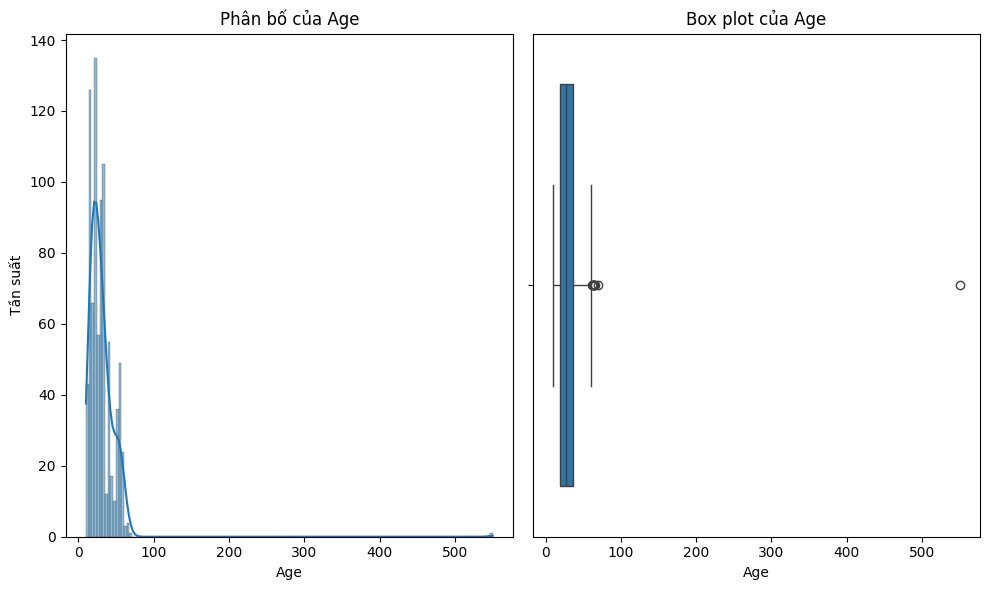

In [294]:
plot_distribution(df, 'Age')

In [295]:
df.Age.unique()

array([ 25,  35,  29,  30,  23,  32,  20,  15,  50,  10,  40,  21,  18,
        16,  19,  22,  49,  28,  12,  60,  55,  45,  42,  26,  54,  44,
        33,  13, 550,  48,  34,  38,  39,  63,  17,  14,  37,  51,  62,
        43,  65,  66,  56,  70,  27,  36,  31,  59,  24,  41,  46])

In [296]:
df['Age'] = df['Age'].replace(550, 55)

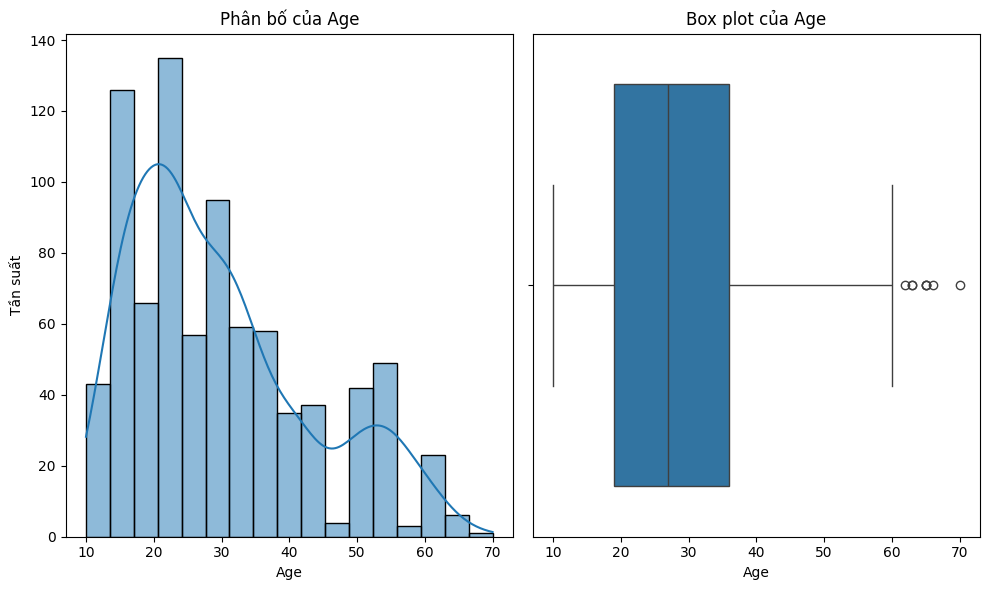

In [297]:
plot_distribution(df, 'Age')

10 - 52
Link: https://www.invitra.com/en/mother-at-50/

In [298]:
df["Age"] = df["Age"].clip(lower=10, upper=52)

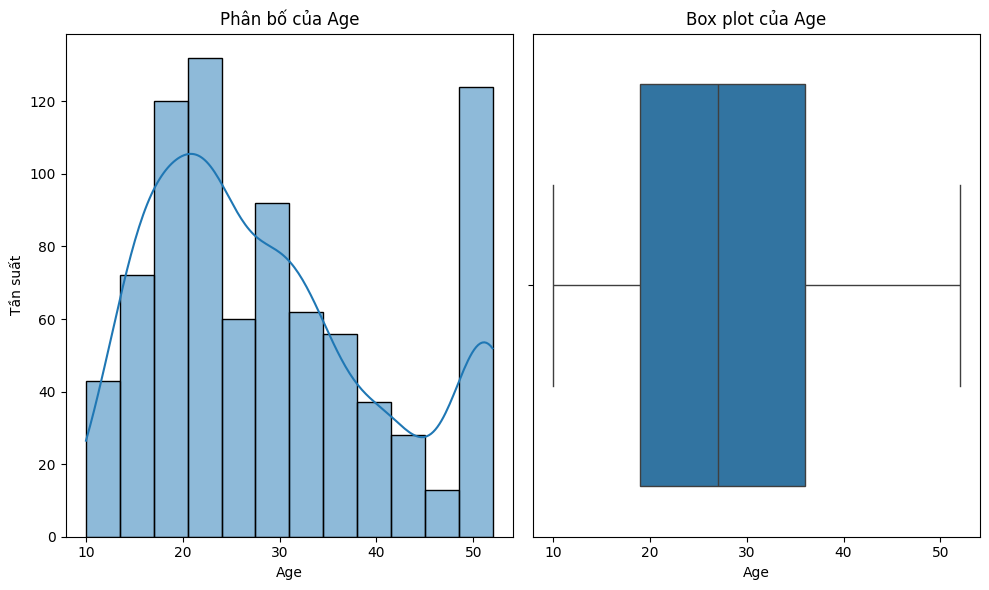

In [299]:
plot_distribution(df, 'Age')

### SystolicBP

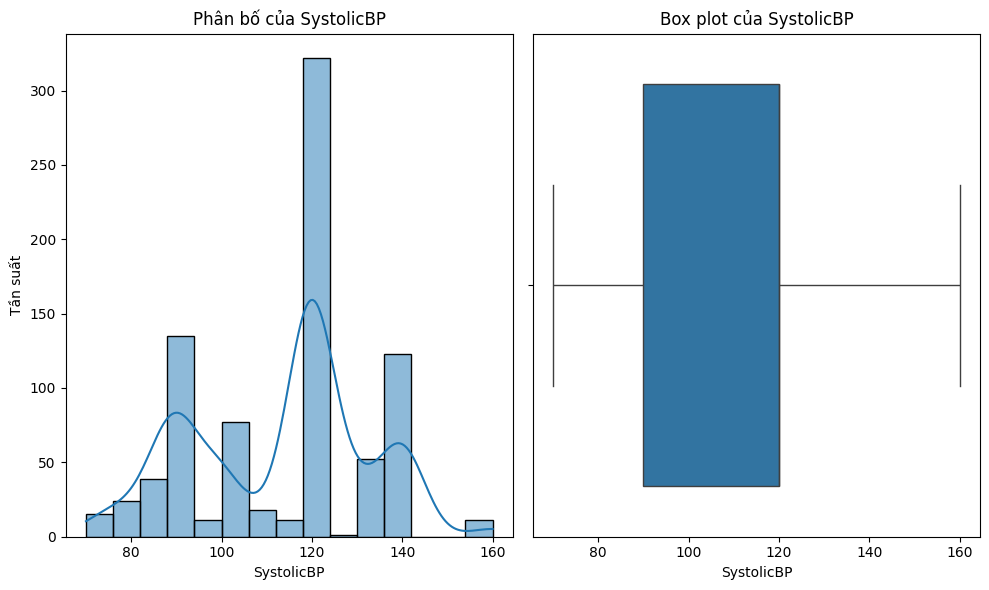

In [300]:
plot_distribution(df, 'SystolicBP')

### DiastolicBP

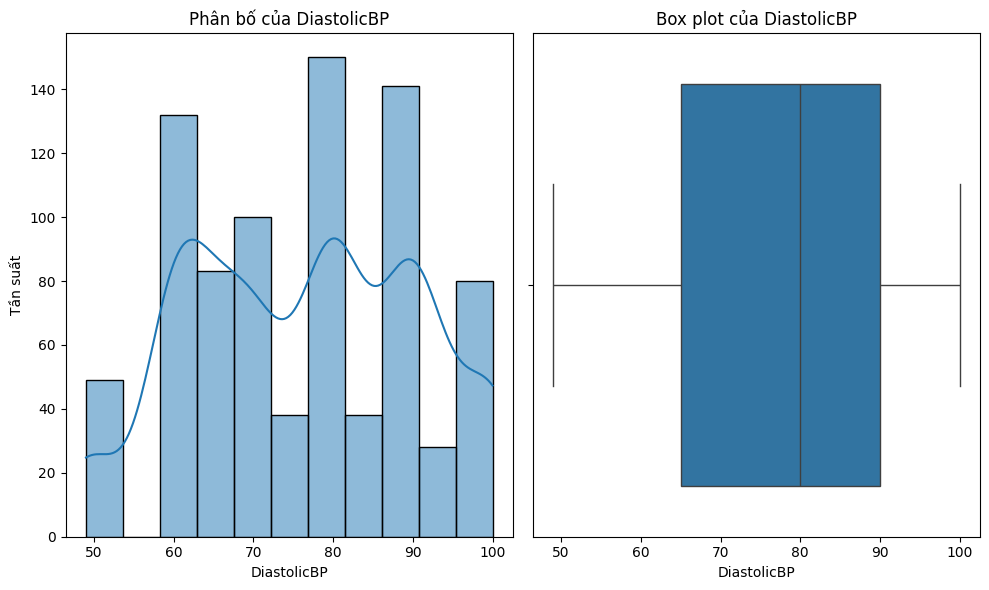

In [301]:
plot_distribution(df, 'DiastolicBP')

### BS

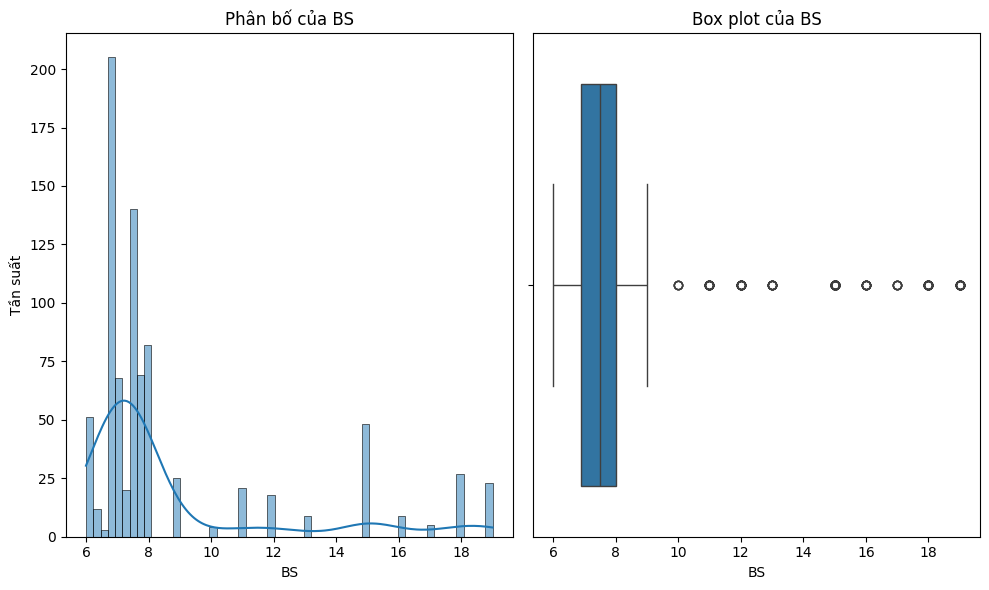

In [302]:
plot_distribution(df, 'BS')

In [303]:
df.BS.unique()

array([15.  , 13.  ,  8.  ,  7.  ,  7.01, 11.  ,  6.9 , 18.  ,  6.7 ,
        7.5 ,  7.2 ,  7.1 ,  6.1 ,  6.4 ,  6.  ,  7.7 , 12.  , 16.  ,
        7.8 ,  6.8 ,  7.9 , 17.  ,  9.  , 19.  , 10.  ,  6.3 ,  6.6 ,
        6.5 ,  7.6 ])

In [304]:
df["BS"] = df["BS"].clip(lower=6, upper=9)

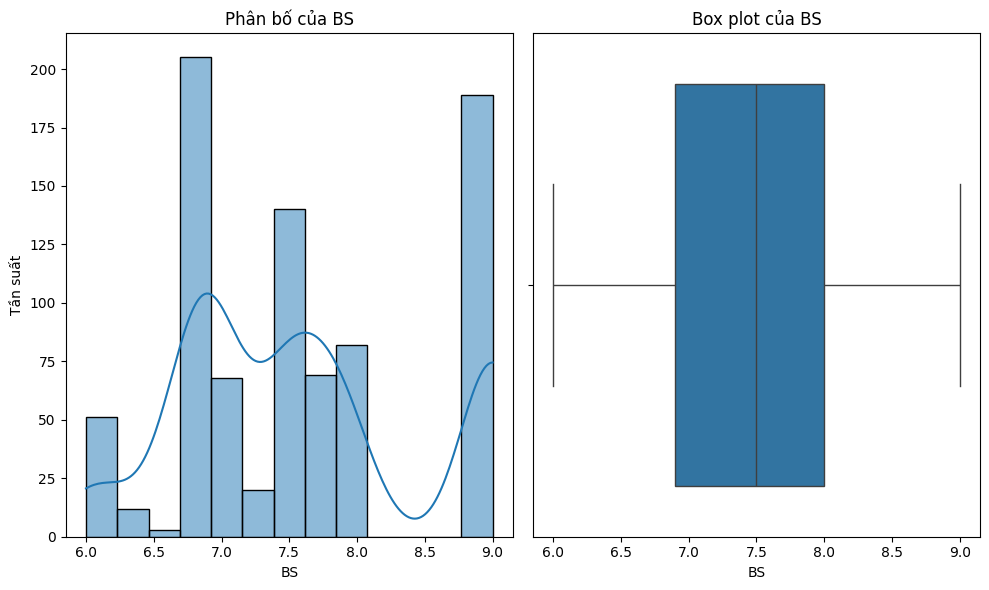

In [305]:
plot_distribution(df, 'BS')

### BodyTemp

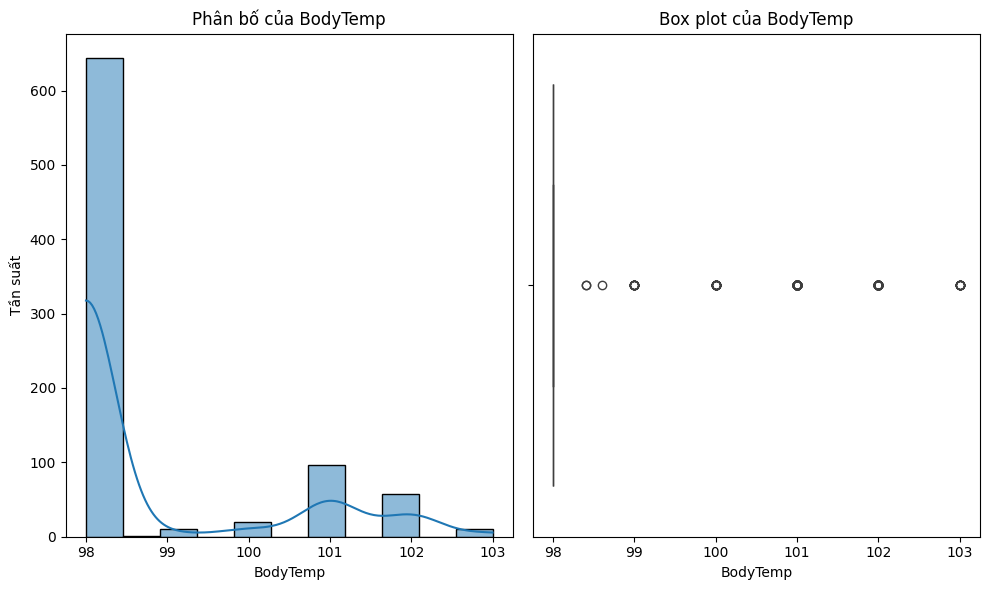

In [306]:
plot_distribution(df, 'BodyTemp')

In [307]:
df.groupby("RiskLevel")["BodyTemp"].mean()

/tmp/ipython-input-895977134.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("RiskLevel")["BodyTemp"].mean()


,BodyTemp
RiskLevel,
0,98.365698
1,99.024490
2,98.978400


In [308]:
df = df.drop('BodyTemp', axis=1)

### HeartRate

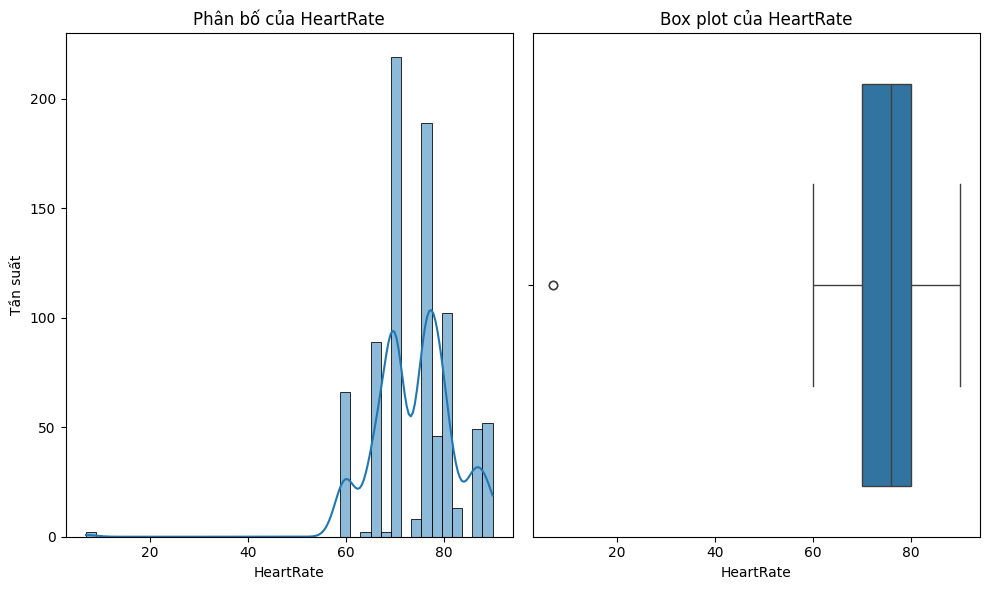

In [309]:
plot_distribution(df, 'HeartRate')

In [310]:
df['HeartRate'] = df['HeartRate'].replace(7, 70)

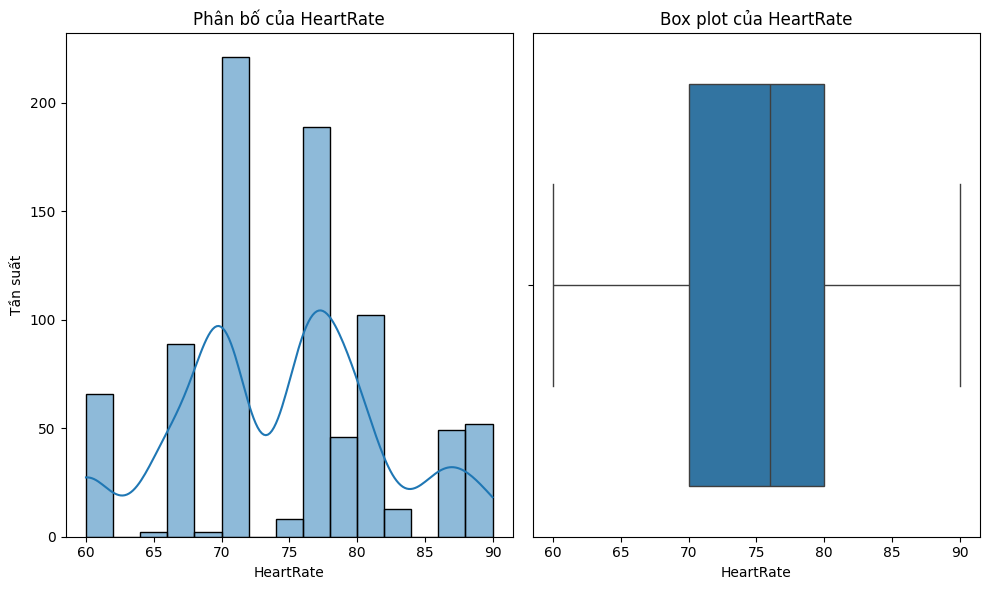

In [311]:
plot_distribution(df, 'HeartRate')

# Phân tích trực quan

## Trực quan hóa DL qua biểu đồ

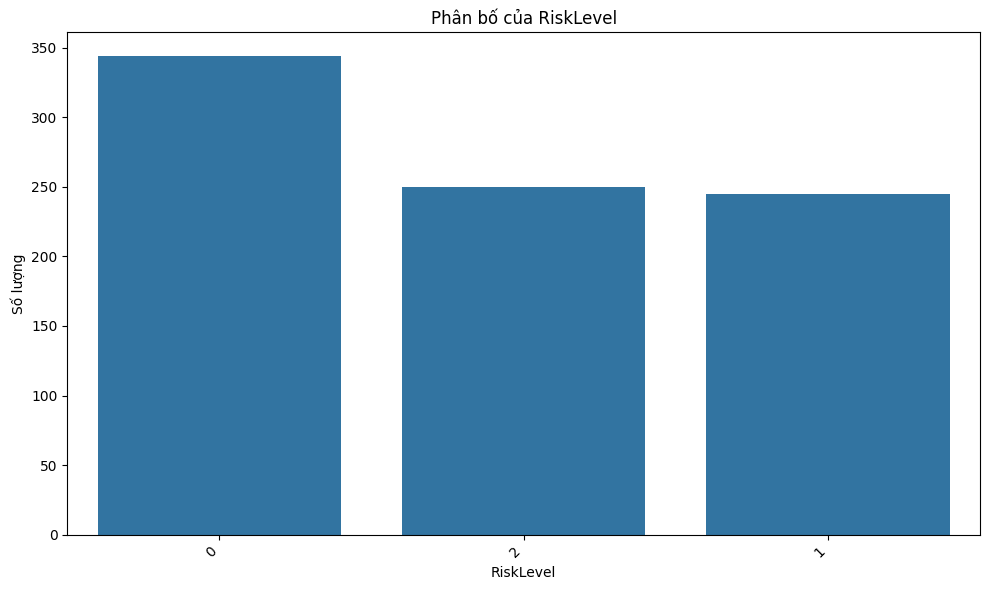

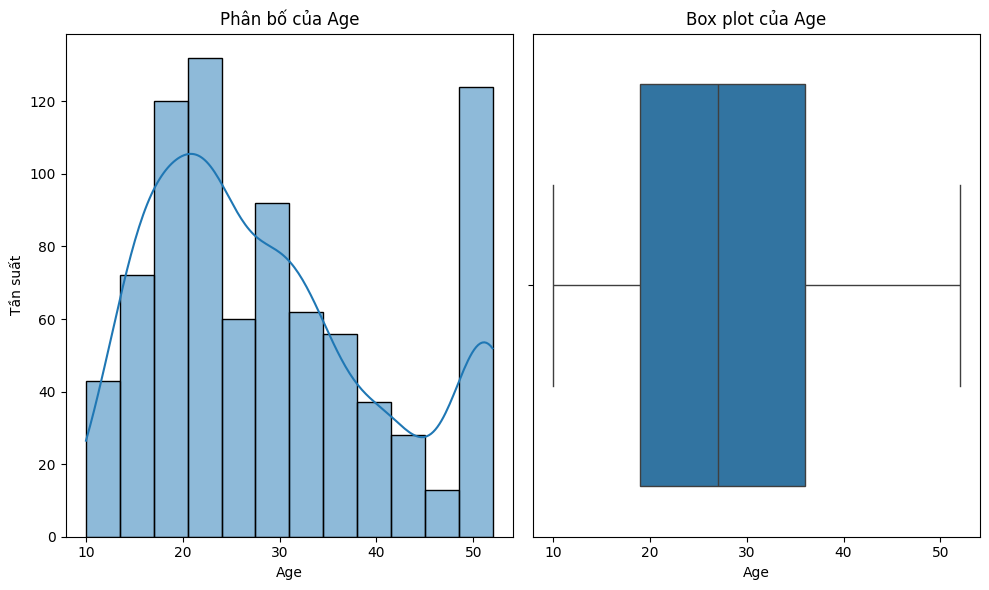

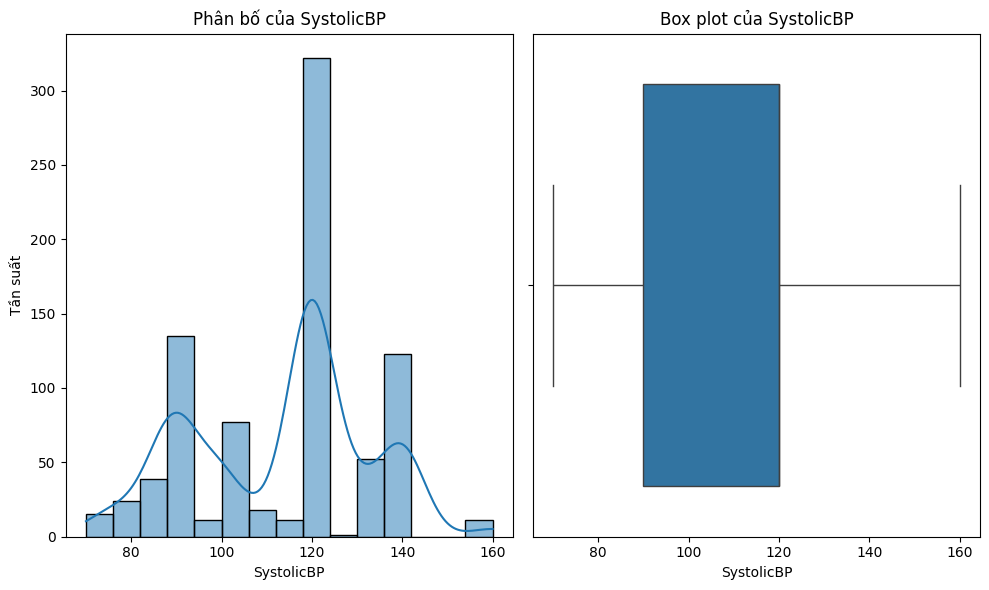

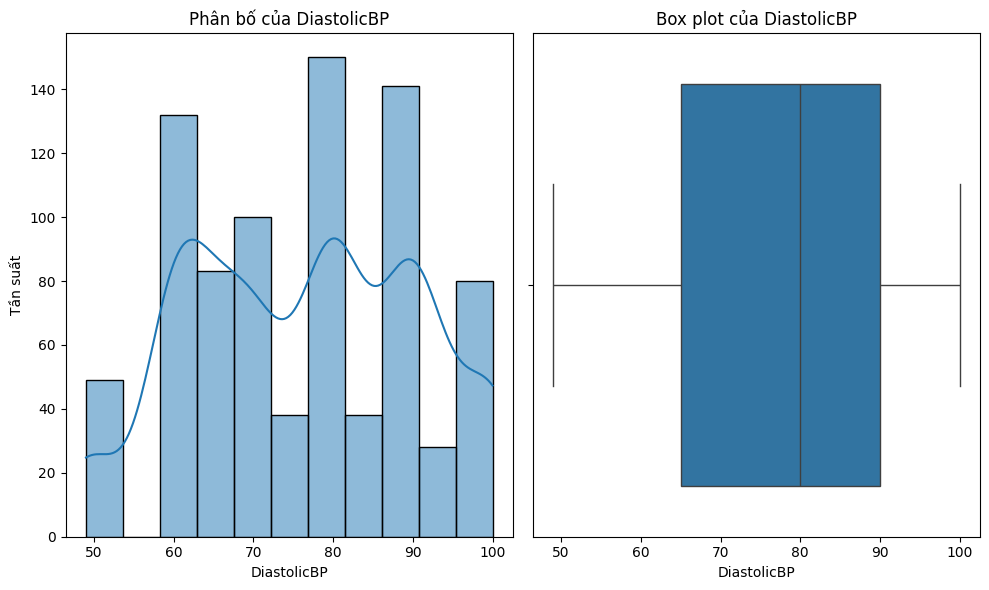

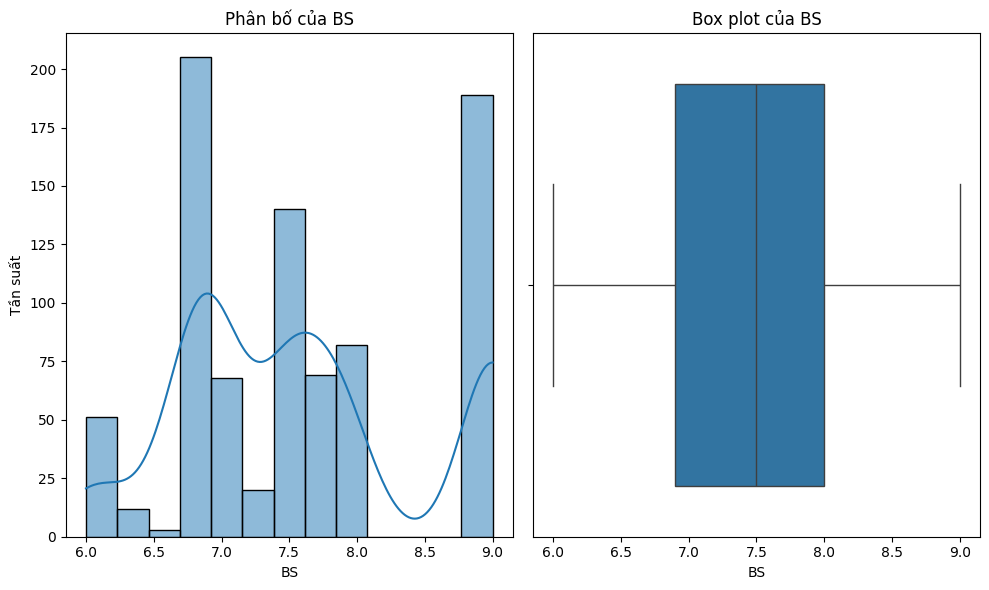

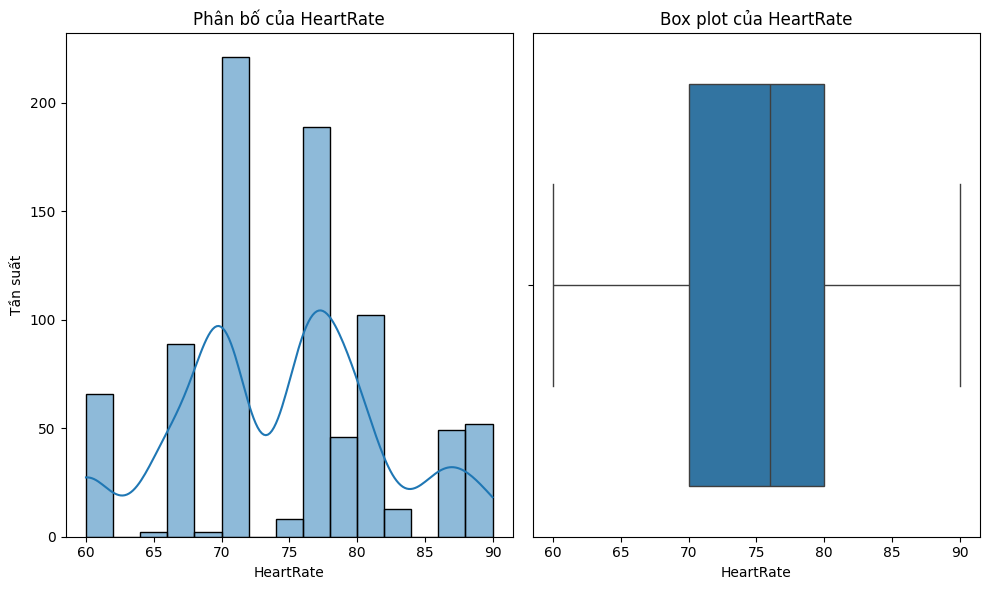

In [312]:
for cot in df.columns:
  plot_distribution(df, cot)

## Định nghĩa hàm vẽ biểu đồ tương quan

In [313]:
def plot_correlation_heatmap(df):
    """
    Vẽ biểu đồ nhiệt ma trận tương quan giữa các biến số trong DataFrame.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Biểu đồ nhiệt ma trận tương quan')
    plt.show()

## Biểu đồ tương quan

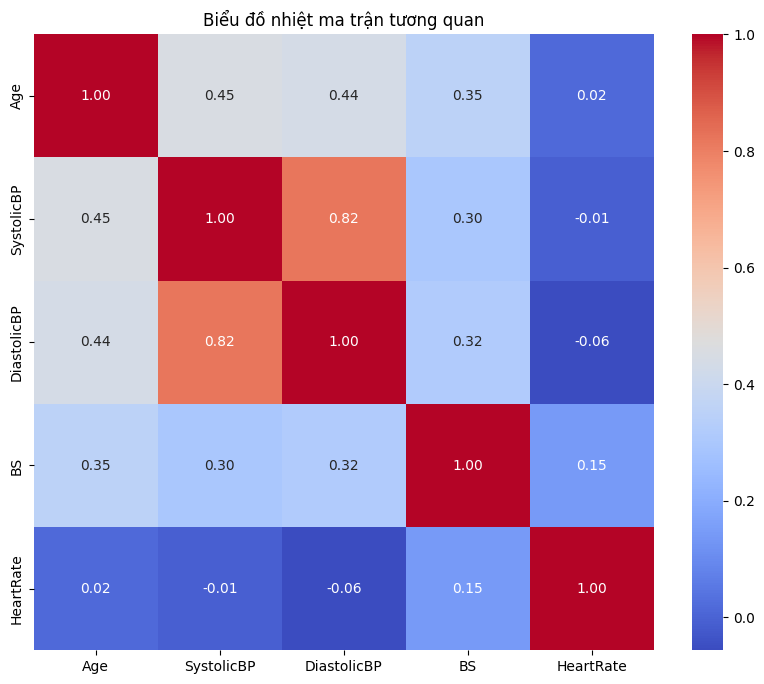

In [314]:
plot_correlation_heatmap(df)

### Xử lý tình trạng tương quan cao của SP và DP bằng cách tạo thêm MAP theo công thức

MAP = DP + 1/3 (SP - DP)

Link: https://www.ncbi.nlm.nih.gov/books/NBK538226/?utm_source=chatgpt.com

In [315]:
df['MAP'] = df['DiastolicBP'] + (df['SystolicBP'] - df['DiastolicBP']) / 3
df['MAP'] = df['MAP'].astype('float64')

In [316]:
df = df.drop(['DiastolicBP', 'SystolicBP'], axis=1)

### Biểu đồ tương quan

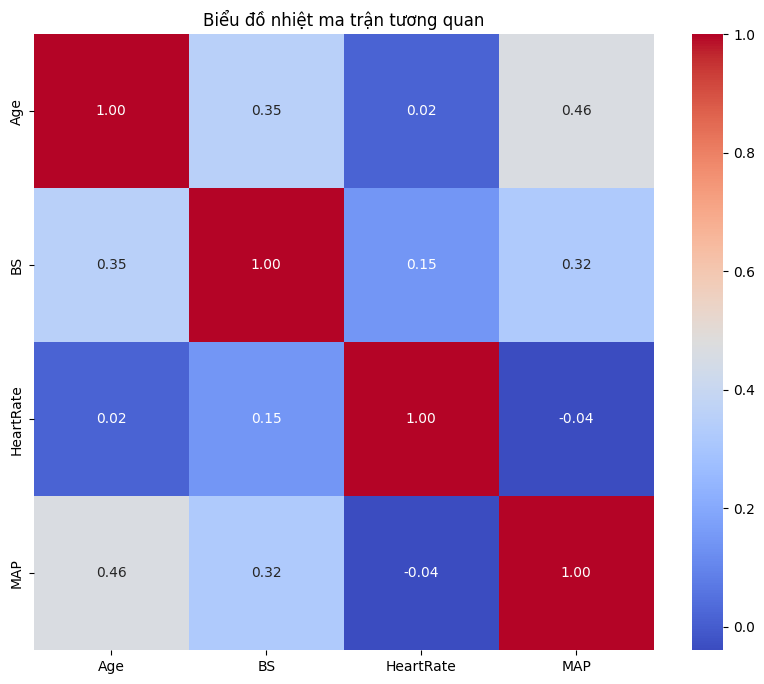

In [317]:
plot_correlation_heatmap(df)

## Trực quan hóa DL qua biểu đồ

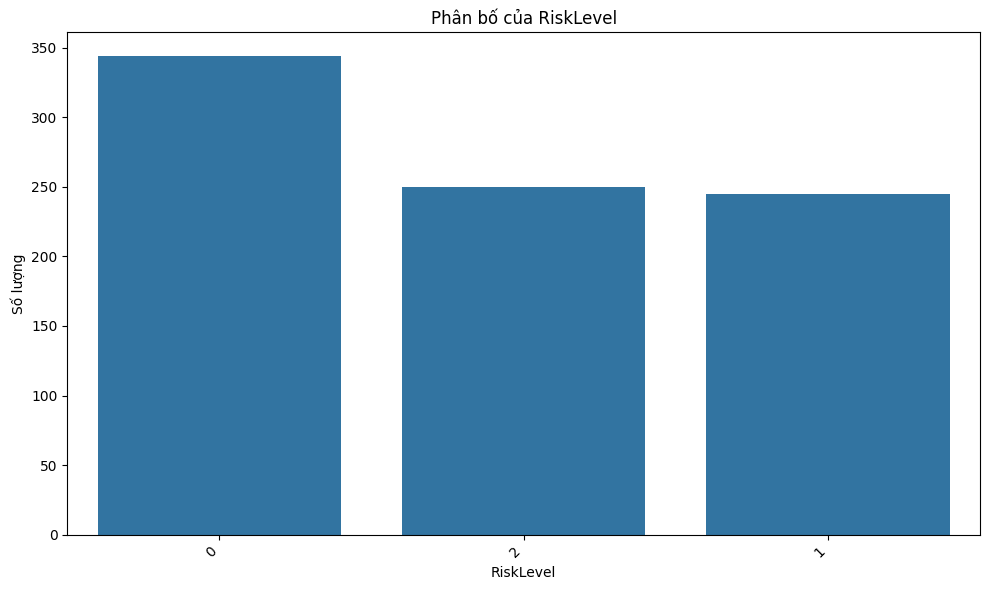

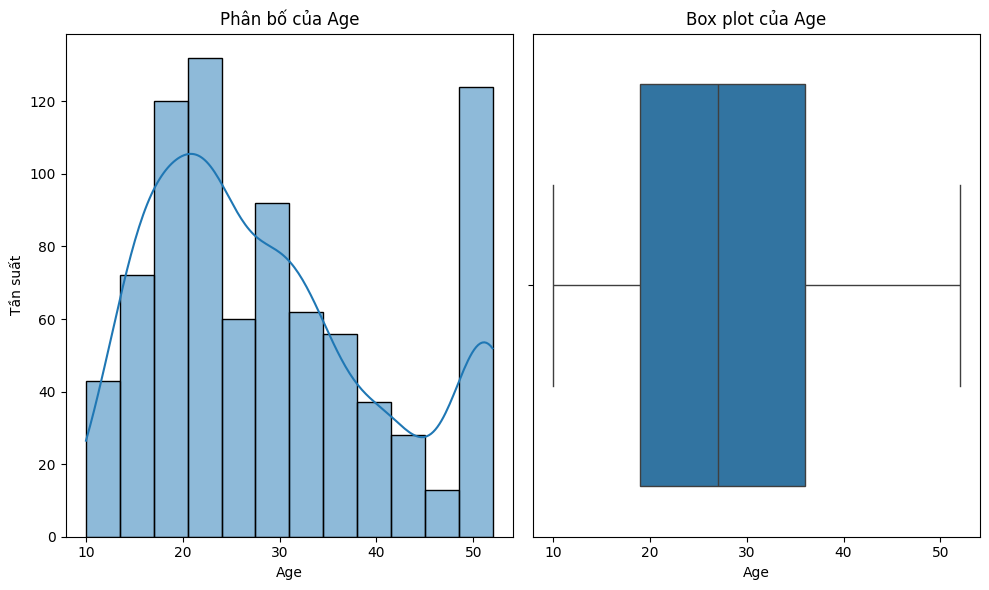

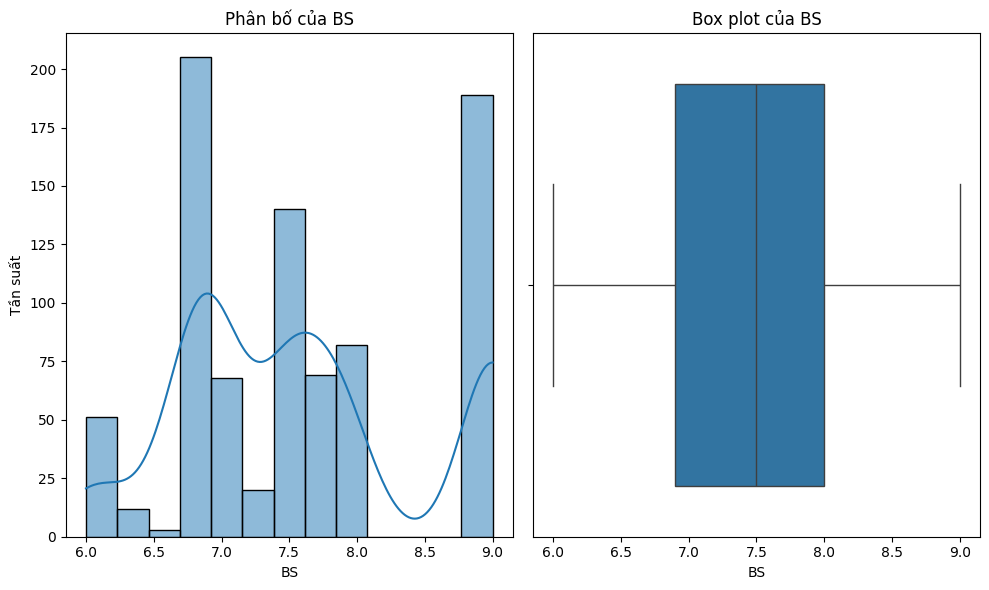

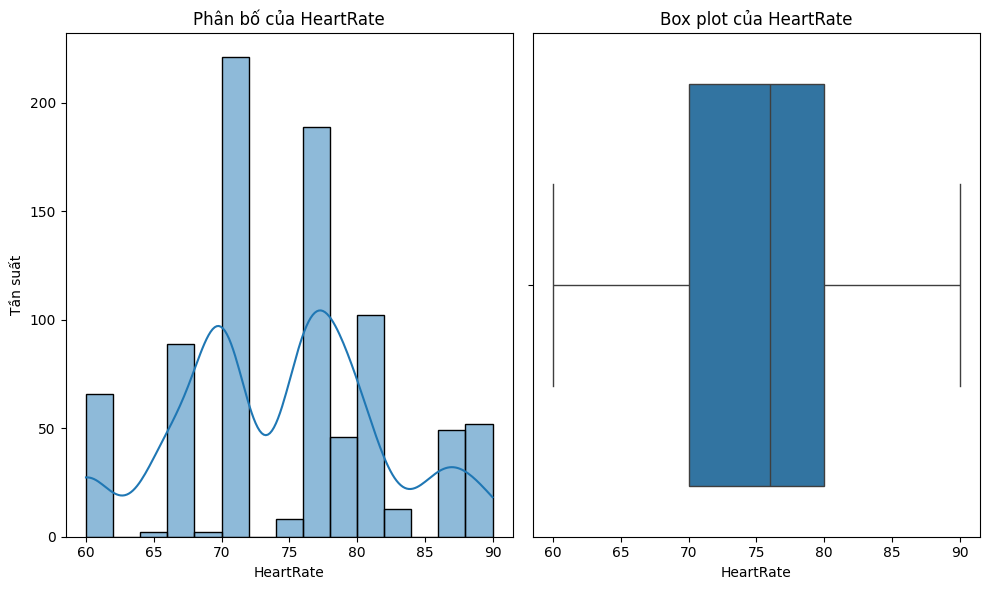

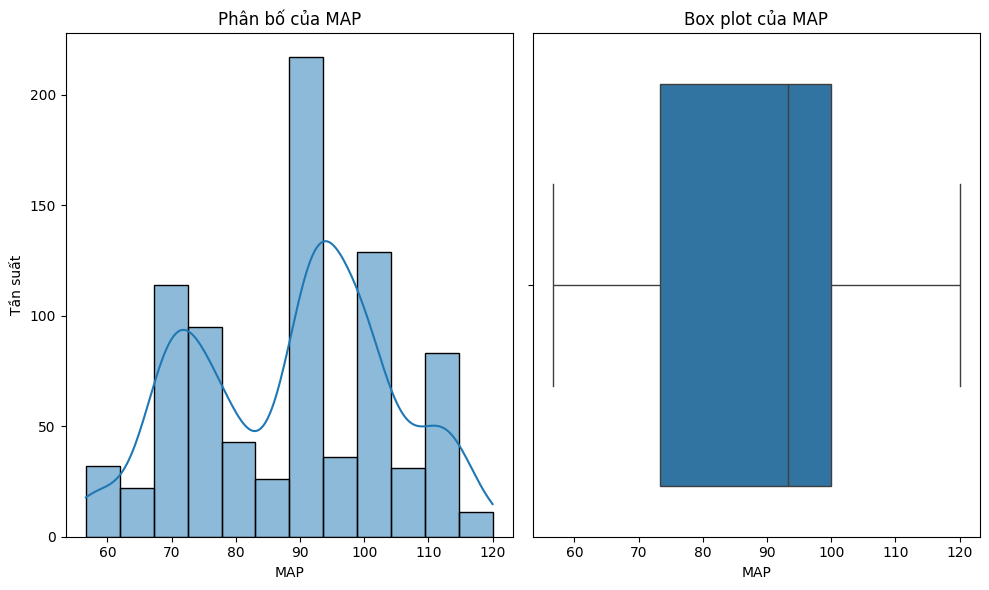

In [318]:
for cot in df.columns:
  plot_distribution(df, cot)

In [319]:
from sklearn.model_selection import train_test_split

X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (671, 4)
Shape of X_test: (168, 4)
Shape of y_train: (671,)
Shape of y_test: (168,)


# Xây dựng mô hình máy học (phân lớp)

In [320]:
from xgboost import XGBClassifier

pipeline_knn = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipeline_dt = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

In [321]:
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11]
}

param_grid_dt = {
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

## Tìm kiếm tham số tốt nhất với gridsearchcv


In [322]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation accuracy for KNN:", grid_search_knn.best_score_)

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best cross-validation accuracy for Decision Tree:", grid_search_dt.best_score_)

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)

Best parameters for KNN: {'knn__n_neighbors': 3}
Best cross-validation accuracy for KNN: 0.7600773908236595
Best parameters for Decision Tree: {'dt__max_depth': None, 'dt__min_samples_split': 2}
Best cross-validation accuracy for Decision Tree: 0.8524709784411277
Best parameters for Random Forest: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best cross-validation accuracy for Random Forest: 0.8688557213930348
Best parameters for XGBoost: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Best cross-validation accuracy for XGBoost: 0.8644112769485904


## Huấn luyện mô hình tốt nhất

Model: KNN
Accuracy on Test Set: 0.8095
Confusion Matrix:


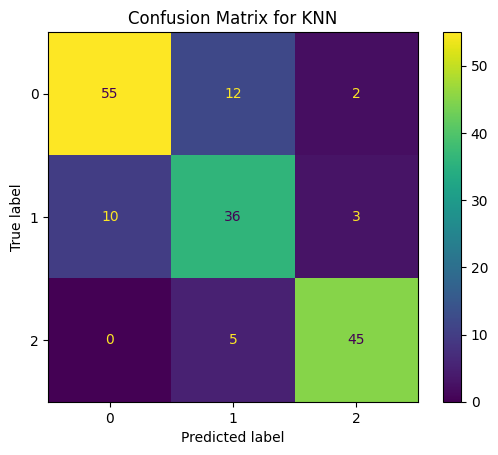

------------------------------
Model: Decision Tree
Accuracy on Test Set: 0.9345
Confusion Matrix:


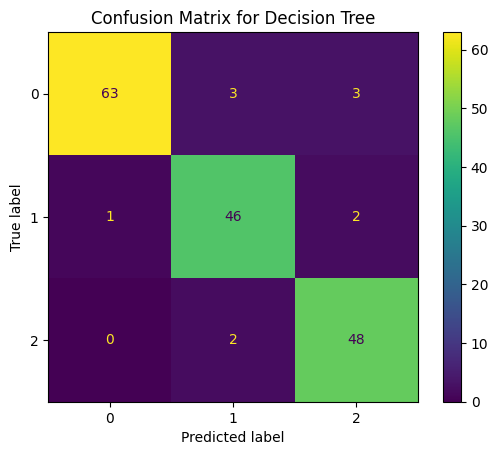

------------------------------
Model: Random Forest
Accuracy on Test Set: 0.9286
Confusion Matrix:


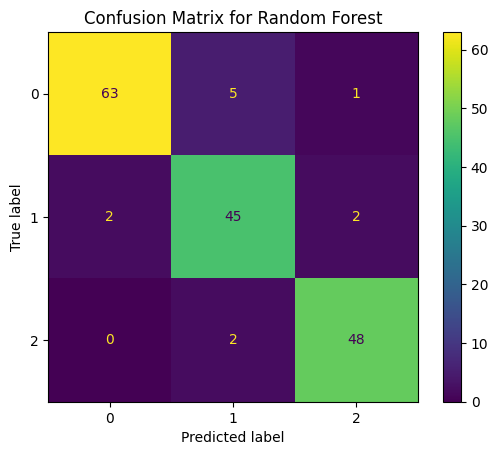

------------------------------
Model: XGBoost
Accuracy on Test Set: 0.9226
Confusion Matrix:


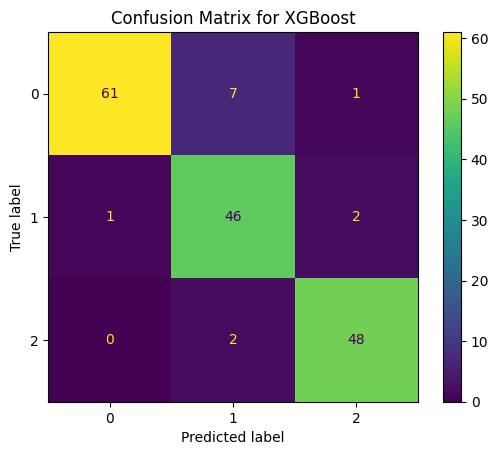

------------------------------


In [323]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_knn_model = grid_search_knn.best_estimator_
best_dt_model = grid_search_dt.best_estimator_
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = grid_search_xgb.best_estimator_

models = {
    "KNN": best_knn_model,
    "Decision Tree": best_dt_model,
    "Random Forest": best_rf_model,
    "XGBoost": best_xgb_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print("-" * 30)

# Đánh giá mô hình

## Đánh giá mô hình

In [324]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        69
           1       0.68      0.73      0.71        49
           2       0.90      0.90      0.90        50

    accuracy                           0.81       168
   macro avg       0.81      0.81      0.81       168
weighted avg       0.81      0.81      0.81       168

------------------------------
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95        69
           1       0.90      0.94      0.92        49
           2       0.91      0.96      0.93        50

    accuracy                           0.93       168
   macro avg       0.93      0.94      0.93       168
weighted avg       0.94      0.93      0.93       168

------------------------------
Classification Report for Random Forest:
              precision    recall  f1-score   support

        

# Lưu mô hình

In [325]:
import joblib

# Lưu mô hình Decision Tree tốt nhất
joblib.dump(best_dt_model, '/content/drive/MyDrive/CT312/main_model.pkl')
print("Decision Tree model saved to /content/drive/MyDrive/CT312/main_model.pkl")

Decision Tree model saved to /content/drive/MyDrive/CT312/main_model.pkl
